In [2]:
#importing the required libraries

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
#user controlled variables

start = 1 #initial condition : fraction of infected individuals

p = 1  #probability of dose transfer upon interaction
rho = 1   #probability of becoming susceptible after recovery
r = 1    #probability of recovery when dose level drops below threshold

N = np.int32(10)    #number of individuals
T = np.int32(10)    #number of time steps

mem_time_steps = 2 #the number of previous time steps which the individual remembers about 

d_star = np.ones((N,1),dtype=np.int32)
# print(d_star)
# print(type(d_star))
# print(d_star.shape)

In [4]:
#initialising variables and arrays to store information

kount = 0

phi_star = 999*np.ones((N,2)) #fraction of steady state infected
# print('phi_star')
# print(phi_star)
# print(phi_star.shape)

phi = 999*np.ones((N,T)) #fraction of steady state infected
# print('phi')
# print(phi)
# print(phi.shape)

t = np.arange(0,T) #time steps
# t = np.asarray(t)
# print('t')
# print(t)
# print(t.shape)
# print(type(t))

indi = 999*np.ones((N,T),dtype=np.int32) #will be used to obtain pairs
indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
indi_state[:,0] = 1
# print('indi')
# print(indi)
# print(type(indi))
# print('indi_state')
# print(indi_state)
# print(type(indi_state))

d = 999*np.ones((N,T)) #doses
D = 999*np.ones((N,T)) #cumulative doses
print('d')
# print(d)
# print(type(d))
# print('D')
# print(D)
# print(type(D))

z1 = 2*np.ones((N,T)) #stores the random numbers for deciding the dose transfer
z2 = 2*np.ones((N,T)) #stores the random numbers for deciding resusceptibility upon recovery
z3 = 2*np.ones((N,T)) #stores the random numbers for deciding immunity upon recovery
# print(z1)
# print(type(z1))

d


In [5]:
#initial state of individuals
#randomly grouping into i, s or r

infec = random.sample(range(0, N), np.int32(start*N)) #radnomly infecting few individuals as initial condition
# np.random.shuffle(infec)
infec = np.asarray(infec).reshape(np.int32(start*N),1)
indi_state[infec[:,0],0] = 2
# print('infec')
# print(type(infec))
# print(infec)
# print('indi_state')
# print(indi_state)

phi[:,0] = indi_state[:,0]
# print('phi')
# print(phi)

In [6]:
#creating the static Watts-Strogatz network

G = nx.watts_strogatz_graph(N,2,0) #no rewiring for now

# #relabelling the nodes to start with 1
# G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

#getting the nodes as a list
node_list = [G.nodes]

#and converting it into an array(column vector)

node_array = np.asarray(node_list).reshape(N,1)
# print('node_array')
# print(node_array)
# print(node_array.shape)
# print(type(node_array))

#obtaining the edges via the adjancency matrix
adj_mat = nx.adjacency_matrix(G)
# print(adj_mat)

# nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')

In [7]:
#randomly shuffling inorder to make pairs 
np.random.shuffle(node_array)
# print(node_array)
indi[:,1] = node_array[:,0]
# print(indi)

In [8]:
kount = 0
val = np.int32(N/2)
for k in range(1,T): #loop for time
#     print(k)
    np.random.shuffle(node_array)
    indi[:,k] = node_array[:,0] #pairing random nodes at each time step
#     print(indi[:,k])
    
    for n in range(0,val): #loop for nodes
#         print(n)
        z1[indi[n,k],k] = np.random.uniform()
        z1[indi[val+n,k],k] = z1[indi[n,k],k]
        
        #if one is infected and the other is susceptible and they are connected 
        if (adj_mat[indi[n,k],indi[val+n,k]] == 1) and (indi_state[indi[n,k],k-1] == 1) and (indi_state[indi[val+n,k],k-1] == 2) :
            if p >= z1[indi[n,k],k] :
#                 print('postive dose to the one')
                d[indi[n,k],k] = 1 #the one receives constant dose
                d[indi[val+n,k],k] = 0 #the other receives no dose
            else :
#                 'interaction but no dose'
                d[indi[n,k],k] = 0
                d[indi[val+n,k],k] = 0
        #if other is infected and the one is susceptible and they are connected
        elif (adj_mat[indi[n,k],indi[val+n,k]] == 1) and (indi_state[indi[n,k],k-1] == 2) and (indi_state[indi[val+n,k],k-1] == 1) :
            if p >= z1[indi[val+n,k],k] :
#                 'postive dose to the other'
                d[indi[val+n,k],k] = 1 #the other receives constant dose
                d[indi[n,k],k] = 0 #the one receives no dose
            else :
#                 'interaction but no dose'
                d[indi[val+n,k],k] = 0 
                d[indi[n,k],k] = 0
        #if both are infected and they are connected
        elif (adj_mat[indi[n,k],indi[val+n,k]] == 1) and (indi_state[indi[n,k],k-1] == 2) and (indi_state[indi[val+n,k],k-1] == 2) :
            if p >= z1[indi[n,k],k] :
#                 'postive dose for both'
                d[indi[val+n,k],k] = 1 #the other receives constant dose
                d[indi[n,k],k] = 1 #the one receives constant dose
            else :
#                 'interaction but no dose'
                d[indi[val+n,k],k] = 0
                d[indi[n,k],k] = 0
        else :
#             'no interaction at all'
                d[indi[n,k],k] = 0
                d[indi[val+n,k],k] = 0
        
        
#     updating cumulative dose
    D[:,k] = 0
    m = k - (mem_time_steps)
    if m > 0 :
        D[:,k] = np.sum(d[:,m:k+1:1],1)
    while m <= 0 :
        m = m + 1
    D[:,k] = np.sum(d[:,m:k+1:1],1)
    
    for n in range (0,N) :
#         print(n)
#         print(k)
#         if threshold is met and is susceptible
        if (D[n,k] >= d_star[n,0]) and (indi_state[n,k-1] == 1) :
#             'above thresh becomes infected'
            indi_state[n,k] = 2 #susceptible becomes infected
        elif (D[n,k] < d_star[n,0]) and (indi_state[n,k-1] == 2) :
#         recovery : if drops bel threshold and is infected
            z2[n,k] = np.random.uniform()
            if r >= z2[n,k] :
#                 'below thresh'
                z3[n,k] = np.random.uniform()
                if rho >= z3[n,k] :
#                     'below thresh becomes susceptible'
                    indi_state[n,k] = 1
                else :
#                     'below thresh becomes immune'
                    indi_state[n,k] = 3
            else :
#                 'below thresh stays infected'
                indi_state[n,k] = 2
        else :
#             'retains previous state'
            indi_state[n,k] = indi_state[n,k-1]
    
    phi[kount,k] = np.count_nonzero(indi_state[:,k] == 2)/N
#     print(indi_state)
#     print(np.count_nonzero(indi_state[:,k] == 2))
#     print([phi[kount,k]])
#     print(kount)
#     print(k)
#     print(n)
#     kount = kount + 1


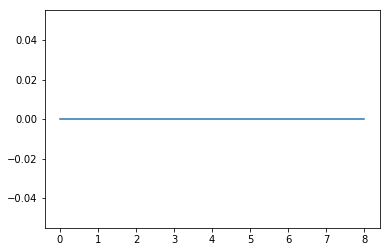

In [9]:
#printing out the necessary variables
# print(d)
# print(D)
# print(z1)

plt.plot(phi[0,1:])
plt.show()